In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import pdb


from itertools import zip_longest, product, chain
import random
from pathlib import Path
import torch
import torch.nn as nn
from torch.nn.functional import binary_cross_entropy_with_logits
import torchvision.transforms.functional as F
from torch.optim import SGD
from torch.utils.data import Dataset
from torchvision.transforms.functional import (pad, to_tensor, normalize,
                                               hflip, vflip, crop)


from utils import plot_cells, plot_masks, plot_mask_cells, convert_cell_to_img

torch.manual_seed(0);

from PIL import Image
from IPython.display import display

In [3]:
def get_jpg_files(folder):
    """폴더 내의 모든 JPG 파일의 이름을 반환합니다."""
    return {f for f in os.listdir(folder) if f.endswith('.jpg')}

def find_common_files(folder1, folder2):
    """두 폴더 내에 동일한 이름을 가진 JPG 파일의 리스트를 반환합니다."""
    files1 = get_jpg_files(folder1)
    files2 = get_jpg_files(folder2)
    common_files = files1 & files2
    return list(common_files)

# 폴더 경로를 설정합니다.
folder1 = os.path.join('data','image')
folder2 = os.path.join('data','mask')

# 동일한 이름을 가진 JPG 파일 리스트를 추출합니다.
common_jpg_files = find_common_files(folder1, folder2)

print(f"Common JPG files:{len(common_jpg_files)}")
for file in common_jpg_files[:3]:
    print(file)

Common JPG files:206
frame_0102_part_3_time_47.60.jpg
frame_0073_part_1_time_34.07.jpg
frame_0100_part_2_time_46.67.jpg


In [4]:
class CellsDataset(Dataset):  
    """이미지, 마스크를 읽고 RGB, L형식으로 변환"""
    def __init__(self, sample_dirs):
        super().__init__()
        self.sample_dirs = sample_dirs

    def __len__(self):
        return len(self.sample_dirs)

    def __getitem__(self, idx):
        sample_dir = self.sample_dirs[idx]
        img_fn = os.path.join('data','image',sample_dir.name)
        mask_fn = os.path.join('data','mask',sample_dir.name)

        image, mask = Image.open(img_fn).convert('RGB'), Image.open(mask_fn).convert('L')
        assert image.size == mask.size
        return image, mask, sample_dir

In [140]:
# Training, validation sample 분할
train_dirs = [Path(d) for d in common_jpg_files[16:]]
valid_dirs = [Path(d) for d in common_jpg_files[:16]]

train_cell_ds = CellsDataset(train_dirs)
valid_cell_ds = CellsDataset(valid_dirs)

img0, mask0, _ = train_cell_ds[0]
#display(img0)
train_dirs[:3], img0.size, type(mask0), valid_dirs[:3]

([WindowsPath('frame_0063_part_1_time_29.40.jpg'),
  WindowsPath('frame_0072_part_3_time_33.60.jpg'),
  WindowsPath('frame_0053_part_3_time_24.73.jpg')],
 (1080, 640),
 PIL.Image.Image,
 [WindowsPath('frame_0102_part_3_time_47.60.jpg'),
  WindowsPath('frame_0073_part_1_time_34.07.jpg'),
  WindowsPath('frame_0100_part_2_time_46.67.jpg')])

In [230]:
# def calcuate_bboxes(im_shape, patch_size):
#     h, w = im_shape  # 640,1080
#     ph, pw = patch_size  # 256,256
#     # range(0, h - ph, ph)=0부터 1080-256=824까지 256간격으로 값 생성
#     steps_h = chain(range(0, h - ph, ph), [h - ph]) 
#     steps_w = chain(range(0, w - pw, pw), [w - pw])

#     return product(steps_h, steps_w)


def calculate_bboxes(image_size, patch_size):
    h, w = image_size
    ph, pw = patch_size
    bboxes = []
    for i in range(0, h, ph):
        for j in range(0, w, pw):
            bboxes.append((i, j))
    return bboxes


class Image2Patches():
    '''큰 이미지 받아 작은 여러개의 patch로 분할해 줌'''
    def __init__(self, image_size = (1080,640), patch_size=(256, 256), padding=16):
        self.image_size = image_size
        self.patch_size = patch_size
        self.padding = padding
        self.patch_size_expanded = (patch_size[0] + 2 * padding,
                                    patch_size[1] + 2 * padding)

        w, h = self.image_size
        bboxes = calcuate_bboxes((h, w), self.patch_size)
        self.coords = list(zip_longest([], bboxes, fillvalue=idx))
        print(self.coords)
        
    def get_patches(self, image):
        patches = []
        for idx in range(len(self.coords)):
            cell = image.copy()
            _, (i, j) = self.coords[idx]   
            h, w = self.patch_size_expanded   

            cell = pad(cell, self.padding, padding_mode='reflect')
            cell = crop(cell, i, j, h, w)
            cell = to_tensor(cell)  
            cell = normalize(cell, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            patches.append((cell, (i,j)))

        return patches
        

img0, mask0, _ = valid_cell_ds[0]
im2pch = Image2Patches()
patches = im2pch.get_patches(img0)

[(14, (0, 0)), (14, (0, 256)), (14, (0, 512)), (14, (0, 768)), (14, (0, 824)), (14, (256, 0)), (14, (256, 256)), (14, (256, 512)), (14, (256, 768)), (14, (256, 824)), (14, (384, 0)), (14, (384, 256)), (14, (384, 512)), (14, (384, 768)), (14, (384, 824))]


In [111]:
def show_tensor_image(tensor_image):
    # Convert the tensor to a NumPy array
    np_image = tensor_image.numpy()

    # Transpose the image to (256, 256, 3) from (3, 256, 256)
    np_image = np.transpose(np_image, (1, 2, 0))
    
    # Normalize the image to range [0, 1] if necessary
    np_image = (np_image - np_image.min()) / (np_image.max() - np_image.min())
    
    # Display the image
    plt.imshow(np_image)
    plt.axis('off')  # Turn off axis
    plt.show()

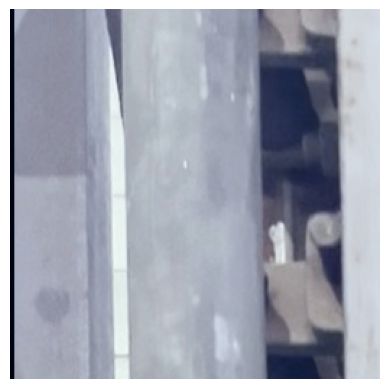

In [132]:
padding = 16
for img, (i,j) in patches:
    show_tensor_image(img[:,padding:-padding,padding:-padding])
    #print(img.shape, (i,j))
    break

In [ ]:
from torchvision import models


def make_decoder_block(in_channels, middle_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, middle_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(
            middle_channels, out_channels, kernel_size=4, stride=2, padding=1),
        nn.ReLU(inplace=True))


class UNet(nn.Module):
    """UNet Model inspired by the the original UNet paper

    Parameters
    ----------
    pretrained: bool (default=True)
        Option to use pretrained vgg16_bn based on ImageNet

    References
    ----------

    .. [1] Olaf Ronneberger, Philipp Fischer, Thomas Brox, 2015,
        "U-Net: Convolutional Networks for Biomedical Image Segmentation,".
        "MICCAI" `<https://arxiv.org/abs/1505.04597>`_
    """
    def __init__(self, pretrained=False):
        super().__init__()
        if pretrained:
            encoder = models.vgg16_bn(weights=models.VGG16_BN_Weights.IMAGENET1K_V1).features
        else:
            encoder = models.vgg16_bn(weights=None).features

        self.conv1 = encoder[:6]
        self.conv2 = encoder[6:13]
        self.conv3 = encoder[13:23]
        self.conv4 = encoder[23:33]
        self.conv5 = encoder[33:43]

        self.center = nn.Sequential(
            encoder[43],  # MaxPool
            make_decoder_block(512, 512, 256))

        self.dec5 = make_decoder_block(256 + 512, 512, 256)
        self.dec4 = make_decoder_block(256 + 512, 512, 256)
        self.dec3 = make_decoder_block(256 + 256, 256, 64)
        self.dec2 = make_decoder_block(64 + 128, 128, 32)
        self.dec1 = nn.Sequential(
            nn.Conv2d(32 + 64, 32, 3, padding=1), nn.ReLU(inplace=True))
        self.final = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        center = self.center(conv5)

        dec5 = self.dec5(torch.cat([center, conv5], 1))
        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(torch.cat([dec2, conv1], 1))

        return self.final(dec1)

In [143]:
model = UNet(pretrained=True).cuda()

In [144]:
model.load_state_dict(torch.load('best_params_0011.pt'))

<All keys matched successfully>

In [231]:
def predict_with_model(image, model, image_to_patches):
    patches = image_to_patches.get_patches(image)
    predictions = []
    model.eval()
    with torch.no_grad():  # Disable gradient calculation for inference
        for patch, (i, j) in patches:
            patch = patch.unsqueeze(0)  # Add batch dimension
            patch = patch.to('cuda')
            mask = model(patch).squeeze()
            mask = mask.cpu().detach().numpy()
            prob_mask = 1/(1 + np.exp(-mask))
            predictions.append((prob_mask, (i, j)))
    return predictions


predictions = predict_with_model(img0, model, im2pch)
len(predictions)

15

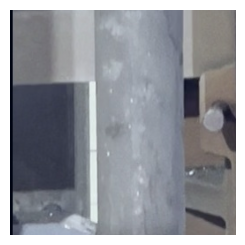

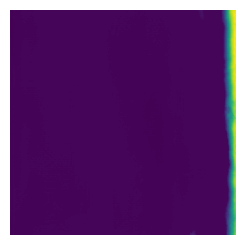

In [232]:
padding = 16
for (patch, (i, j)), (mask, (m, n)) in zip(patches, predictions):
    # Remove padding
    patch_img = patch[:, padding:-padding, padding:-padding]
    mask_img = mask[padding:-padding, padding:-padding]
    
    # Show the patch image
    plt.figure()
    plt.subplot(1, 2, 1)
    show_tensor_image(patch_img)
    
    # Show the mask
    plt.subplot(1, 2, 2)
    plt.imshow(mask_img)  # Convert mask to HWC format
    #plt.title(f"Prediction: {prediction}")
    plt.axis('off')
    
    plt.show()
    break

In [233]:
#[(14, (0, 0)), (14, (0, 256)), (14, (0, 512)), (14, (0, 768)), (14, (0, 824)), (14, (256, 0)), (14, (256, 256)), (14, (256, 512)), 
#   (14, (256, 768)), (14, (256, 824)), (14, (384, 0)), (14, (384, 256)), (14, (384, 512)), (14, (384, 768)), (14, (384, 824))]

# Function to combine patches into a single image
def combine_patches(predictions, image_size, padding):
    combined_image = np.zeros((image_size[1], image_size[0]), dtype=np.uint8)  #(640,1080)
    for patch, (i, j) in predictions:
        patch_img = patch[padding:-padding, padding:-padding]
        patch_img = (patch_img * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8
        h, w = patch_img.shape
        combined_image[i:i+h, j:j+w] = patch_img
    return combined_image


combined_image = combine_patches(predictions, im2pch.image_size, im2pch.padding)

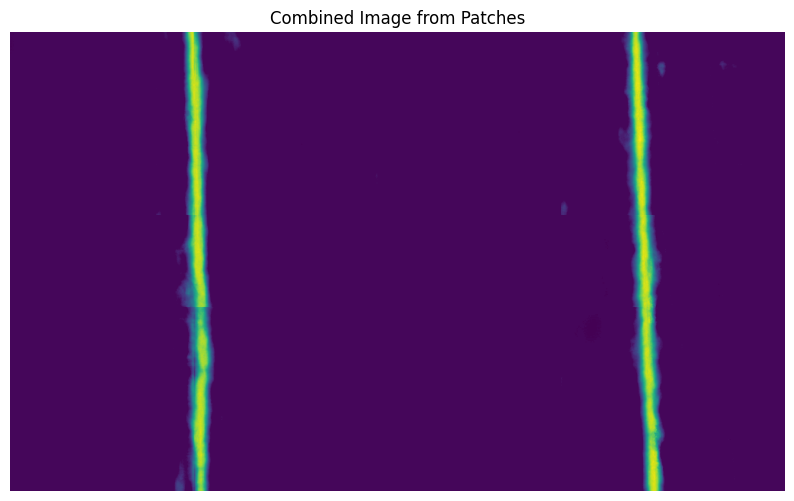

In [234]:
plt.figure(figsize=(10, 10))
plt.imshow(combined_image)
plt.title("Combined Image from Patches")
plt.axis('off')
plt.show()

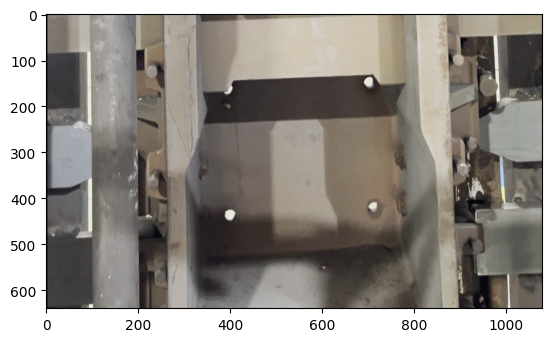

In [235]:
plt.imshow(img0)

In [236]:
def strength_line(image, mask_im, rho, theta, thickness=2, imsize=(256,256)):
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), thickness)

    # 선 위의 모든 픽셀 좌표 계산
    all_line_pixels = []
    for t in np.linspace(0, 1, max(abs(x2 - x1), abs(y2 - y1))):
        x = int(x1 * (1 - t) + x2 * t)
        y = int(y1 * (1 - t) + y2 * t)
        if 0 < x < imsize[0] and 0 < y < imsize[1]:
            all_line_pixels.append((x, y))
            
    total_sum = sum(mask_im[y, x] for x, y in all_line_pixels)
    
    return image, total_sum, all_line_pixels


def points_on_line(org_img, pred_mask, mask_thres=0.7, \
                   wsize=5, sigma=1.4, low_thres=30, high_thres=80, min_length=50):
    ''' '''
    # Get numpy image
    pil_image = convert_cell_to_img(org_img, padding=16)
    image = np.array(pil_image)
    
    #image = np.array(org_img)
    #image = org_img.permute(1, 2, 0).cpu().detach().numpy()
    
    # 가우시안 블러를 사용하여 노이즈 감소
    blurred_image = cv2.GaussianBlur(image, (wsize, wsize), sigma)
    # Canny 에지 검출
    edges = cv2.Canny(blurred_image, low_thres, high_thres)

    result_image = np.where(pred_mask >= mask_thres, edges, 0)  
    lines = cv2.HoughLines(result_image, 1, np.pi / 180, min_length)
    
    return lines, image
    
    
def select_bestline(lines, src_image, pred_mask):
    votes = []
    if lines is not None:
        for idx, (rho, theta) in enumerate(lines[:, 0]):
            res_im, psum, all_line_pixels = strength_line(src_image.copy(), pred_mask, rho, theta)
            votes.append((res_im, psum, all_line_pixels))

        max_element = max(votes, key=lambda x: x[1])
        return max_element

    return None

    
def plot_line(image_id, val_ds, val_prob_masks, padding):
    # 검출된 선을 이미지에 그리기
    org_img, org_mask = val_ds[image_id]
    pred_mask = val_prob_masks[image_id][padding:-padding, padding:-padding] 

    lines, src_image = points_on_line(org_img, pred_mask)
    max_element = select_bestline(lines, src_image, pred_mask)
    if max_element:
        res_im_max, psum_max, all_line_pixels = max_element
        print(f"Maximum psum: {psum_max}, Number of pixels on line: {len(all_line_pixels)}")

        # 이미지 표시
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(res_im_max, cv2.COLOR_BGR2RGB))
        plt.title('Hough Lines')

        plt.subplot(1, 2, 2)
        plt.imshow(pred_mask)
        plt.title('Mask Image')

        plt.show()


In [237]:
combined_image.shape, img0.size

((640, 1080), (1080, 640))

In [238]:
padding = 16
all_lines = []
for (patch, (i, j)), (mask, (m, n)) in zip(patches, predictions):
    # Remove padding
    #patch_img = patch[:, padding:-padding, padding:-padding]
    mask_img = mask[padding:-padding, padding:-padding]
    lines, src_image = points_on_line(patch, mask_img)
    max_element = select_bestline(lines, src_image, mask_img)
    if max_element:
        res_im_max, psum_max, all_line_pixels = max_element
        all_lines.append((all_line_pixels, (i,j)))
        print(f"Maximum psum: {psum_max}, Number of pixels on line: {len(all_line_pixels)}")

#         # 이미지 표시
#         plt.figure(figsize=(12, 6))

#         plt.subplot(1, 2, 1)
#         plt.imshow(cv2.cvtColor(res_im_max, cv2.COLOR_BGR2RGB))
#         plt.title('Hough Lines')

#         plt.subplot(1, 2, 2)
#         plt.imshow(mask_img)
#         plt.title('Mask Image')

#         plt.show()

Maximum psum: 182.3158478140831, Number of pixels on line: 255
Maximum psum: 185.03079533576965, Number of pixels on line: 255
Maximum psum: 185.095110476017, Number of pixels on line: 255
Maximum psum: 181.78766357898712, Number of pixels on line: 255
Maximum psum: 184.08845525979996, Number of pixels on line: 255
Maximum psum: 184.10863089561462, Number of pixels on line: 255
Maximum psum: 180.39654809236526, Number of pixels on line: 255
Maximum psum: 183.16154026985168, Number of pixels on line: 255
Maximum psum: 183.20953577756882, Number of pixels on line: 255


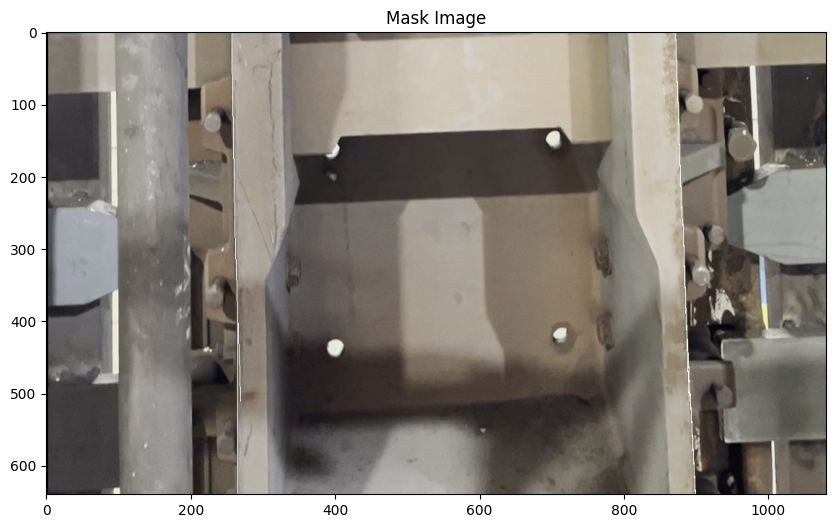

In [239]:
#image = np.zeros((640, 1080), dtype=np.uint8)
#pil_image = convert_cell_to_img(img0, padding=0)
image = np.array(img0)

for v,(ii,jj) in all_lines:
    #print(ii,jj)  #(r,c)
    for i,j in v:
        r, c = ii+j, jj+i
        image[r, c] = 255
        
#이미지 표시
plt.figure(figsize=(12, 6))

#plt.subplot(1, 2, 2)
plt.imshow(image)
plt.title('Mask Image')

plt.show()

In [197]:
# lines, src_image = points_on_line(img0, combined_image)
# max_element = select_bestline(lines, src_image, combined_image)
# if max_element:
#     res_im_max, psum_max, all_line_pixels = max_element
#     print(f"Maximum psum: {psum_max}, Number of pixels on line: {len(all_line_pixels)}")

#     # 이미지 표시
#     plt.figure(figsize=(12, 6))

#     plt.subplot(1, 2, 1)
#     plt.imshow(cv2.cvtColor(res_im_max, cv2.COLOR_BGR2RGB))
#     plt.title('Hough Lines')

#     plt.subplot(1, 2, 2)
#     plt.imshow(combined_image)
#     plt.title('Mask Image')

#     plt.show()